<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/example%20Fuzzy%20outliers%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # Outlier-Robust Fuzzy Regression
# This notebook implements fuzzy regression that identifies and excludes outliers using fuzzy membership functions based on residuals.


import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Install required packages
!pip install -q scikit-fuzzy

import skfuzzy as fuzz

# Generate Data with Significant Outliers

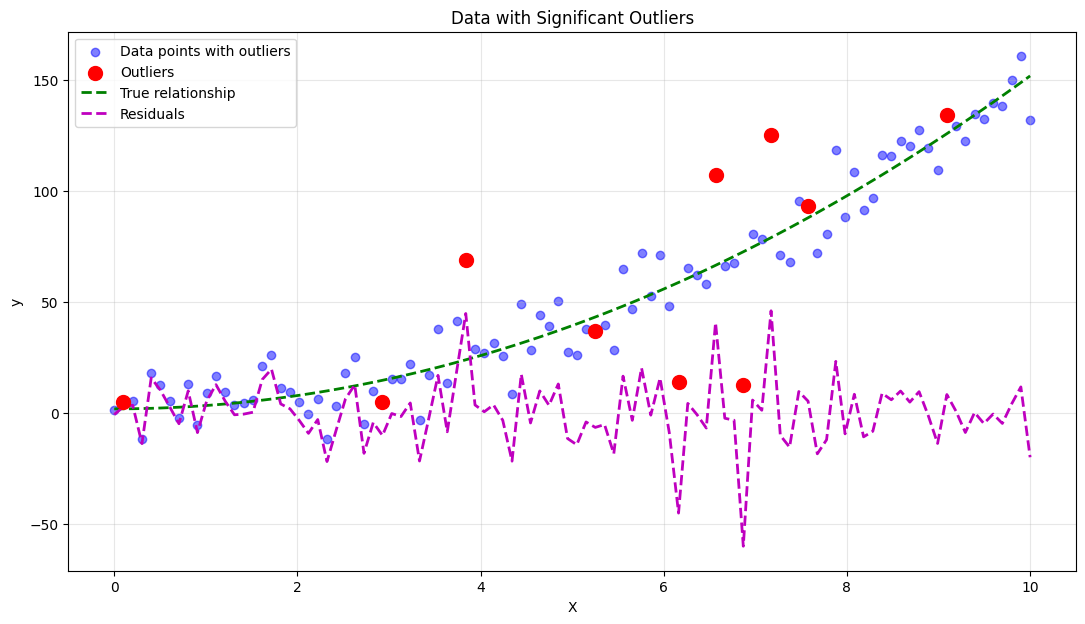

Total data points: 100
Number of outliers: 10 (10.0%)


In [ ]:
# Generate data with significant outliers
np.random.seed(37)
n_samples = 100
X = np.linspace(0, 10, n_samples)

# True relationship
y_true = 1.5 * X*X + 2

# Add noise
noise = np.random.normal(0, 10.5, n_samples)
y_noisy = y_true + noise

# Add significant outliers (10% of data)
n_outliers = int(0.1 * n_samples)
outlier_indices = np.random.choice(n_samples, size=n_outliers, replace=False)
outlier_magnitudes = np.random.normal(0, 40, n_outliers)  # Large outliers
y = y_noisy.copy()
y[outlier_indices] += outlier_magnitudes

# Reshape for sklearn
X_reshaped = X.reshape(-1, 1)

# Plot the data
plt.figure(figsize=(13, 7))
plt.scatter(X, y, alpha=0.5, c='blue', label='Data points with outliers')
plt.scatter(X[outlier_indices], y[outlier_indices], c='red', s=100, label='Outliers', zorder=5)
plt.plot(X, y_true, 'g--', linewidth=2, label='True relationship')
plt.plot(X, y-y_true, 'm--', linewidth=2, label='Residuals')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Data with Significant Outliers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total data points: {n_samples}")
print(f"Number of outliers: {n_outliers} ({n_outliers/n_samples*100:.1f}%)")

# Fuzzy Outlier Detection Based on Residuals

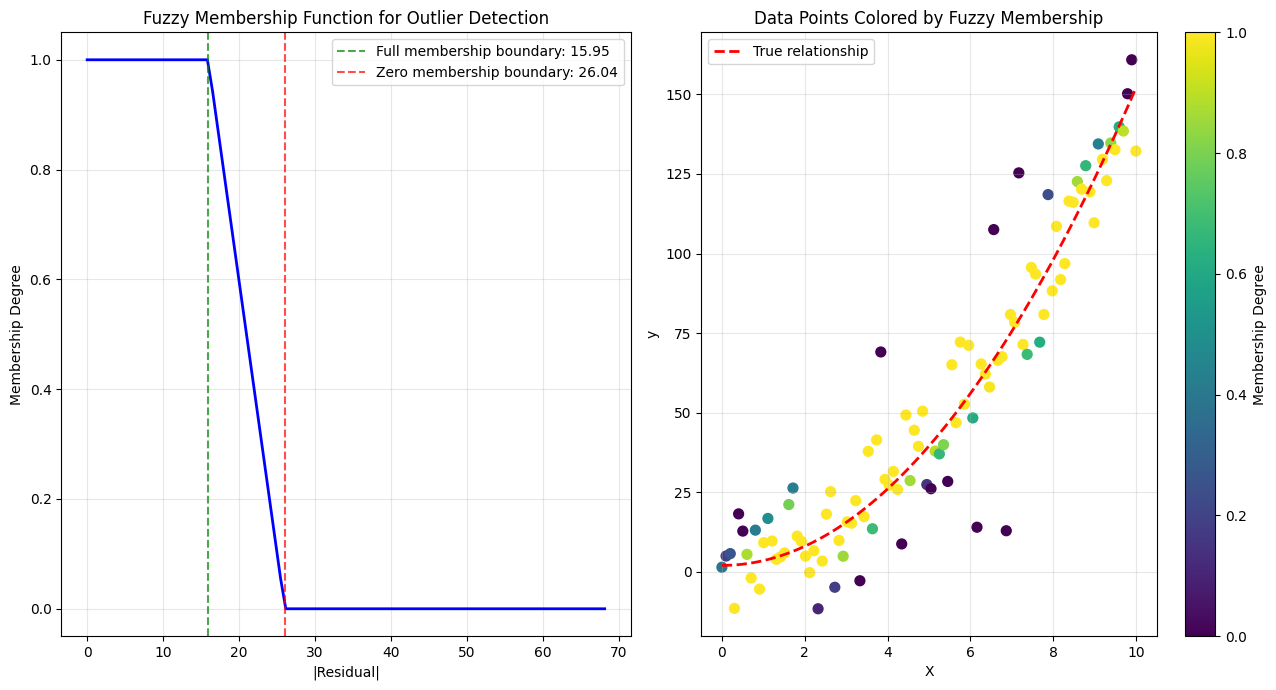

Fuzzy membership boundaries:
  Full membership: |residual| ≤ 15.95
  Partial membership: 15.95 < |residual| ≤ 26.04
  Outlier membership: |residual| > 26.04


In [16]:

def compute_fuzzy_membership_residuals(residuals, threshold_factor=2.0):
    """
    Compute fuzzy membership degrees based on residuals

    Parameters:
    residuals: Array of residuals (y_true - y_pred)
    threshold_factor: Factor to determine fuzzy boundary

    Returns:
    membership_degrees: Membership degrees (1 = inlier, 0 = outlier)
    """
    abs_residuals = np.abs(residuals)

    # Calculate statistics for membership function
    median_res = np.median(abs_residuals)
    mad = np.median(np.abs(abs_residuals - median_res))  # Median Absolute Deviation

    # Define fuzzy membership using trapezoidal function
    # Points with small residuals have high membership (inliers)
    # Points with large residuals have low membership (outliers)

    # Define boundaries for trapezoidal membership function
    a = 0  # Start of full membership
    b = median_res + 0.5 * mad  # End of full membership
    c = median_res + threshold_factor * mad  # Start of zero membership
    d = median_res + 2 * threshold_factor * mad  # End of zero membership

    # Create trapezoidal membership function
    membership = np.zeros_like(abs_residuals)

    # Full membership [0, b]
    mask1 = abs_residuals <= b
    membership[mask1] = 1.0

    # Decreasing membership [b, c]
    mask2 = (abs_residuals > b) & (abs_residuals <= c)
    membership[mask2] = (c - abs_residuals[mask2]) / (c - b)

    # Zero membership [c, inf]
    mask3 = abs_residuals > c
    membership[mask3] = 0.0

    return membership, (a, b, c, d)

# First, get a preliminary fit to compute residuals
initial_model = LinearRegression()
initial_model.fit(X_reshaped, y)
y_initial_pred = initial_model.predict(X_reshaped)
initial_residuals = y - y_initial_pred

# Compute fuzzy memberships based on residuals
membership_degrees, boundaries = compute_fuzzy_membership_residuals(initial_residuals)

# Visualization of membership function
plt.figure(figsize=(13, 7))

# Plot membership function
residual_range = np.linspace(0, np.max(np.abs(initial_residuals)) + 1, 100)
a, b, c, d = boundaries
membership_func = np.zeros_like(residual_range)

mask1 = residual_range <= b
membership_func[mask1] = 1.0

mask2 = (residual_range > b) & (residual_range <= c)
membership_func[mask2] = (c - residual_range[mask2]) / (c - b)

mask3 = residual_range > c
membership_func[mask3] = 0.0

plt.subplot(1, 2, 1)
plt.plot(residual_range, membership_func, 'b-', linewidth=2)
plt.xlabel('|Residual|')
plt.ylabel('Membership Degree')
plt.title('Fuzzy Membership Function for Outlier Detection')
plt.grid(True, alpha=0.3)
plt.axvline(b, color='g', linestyle='--', alpha=0.7, label=f'Full membership boundary: {b:.2f}')
plt.axvline(c, color='r', linestyle='--', alpha=0.7, label=f'Zero membership boundary: {c:.2f}')
plt.legend()

# Plot data points colored by membership
plt.subplot(1, 2, 2)
scatter = plt.scatter(X, y, c=membership_degrees, cmap='viridis', s=50)
plt.colorbar(scatter, label='Membership Degree')
plt.plot(X, y_true, 'r--', linewidth=2, label='True relationship')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Data Points Colored by Fuzzy Membership')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Fuzzy membership boundaries:")
print(f"  Full membership: |residual| ≤ {b:.2f}")
print(f"  Partial membership: {b:.2f} < |residual| ≤ {c:.2f}")
print(f"  Outlier membership: |residual| > {c:.2f}")


#Fuzzy Regression with Outlier Exclusion

In [ ]:

class RobustFuzzyRegression:
    def __init__(self, degree=1, threshold_factor=2.0, max_iterations=5):
        """
        Initialize robust fuzzy regression model

        Parameters:
        degree: Degree of polynomial features (1 = linear)
        threshold_factor: Factor for outlier detection threshold
        max_iterations: Maximum iterations for membership refinement
        """
        self.degree = degree
        self.threshold_factor = threshold_factor
        self.max_iterations = max_iterations
        self.model = None
        self.poly_features = None
        self.membership_history = []
        self.residuals_history = []

    def fit(self, X, y):
        """
        Fit robust fuzzy regression model with outlier exclusion

        Parameters:
        X: Input features (n_samples, n_features)
        y: Target values (n_samples,)
        """
        X = np.array(X)
        y = np.array(y)

        # Create polynomial features
        self.poly_features = PolynomialFeatures(degree=self.degree, include_bias=True)
        X_poly = self.poly_features.fit_transform(X)

        # Initialize memberships
        memberships = np.ones(len(y))

        # Iteratively refine memberships and model
        for iteration in range(self.max_iterations):
            # Weighted fit using current memberships
            self.model = LinearRegression()
            self.model.fit(X_poly, y, sample_weight=memberships)

            # Predict and compute residuals
            y_pred = self.model.predict(X_poly)
            residuals = y - y_pred

            # Update memberships based on residuals
            new_memberships, _ = compute_fuzzy_membership_residuals(
                residuals, self.threshold_factor
            )

            # Store history
            self.membership_history.append(new_memberships.copy())
            self.residuals_history.append(residuals.copy())

            # Check for convergence (small change in memberships)
            if iteration > 0:
                membership_change = np.mean(np.abs(new_memberships - memberships))
                if membership_change < 0.01:  # Convergence threshold
                    break

            memberships = new_memberships

        self.final_memberships = memberships
        self.final_residuals = residuals

        return self

    def predict(self, X):
        """
        Predict using robust fuzzy regression model

        Parameters:
        X: Input features (n_samples, n_features)

        Returns:
        Predicted values
        """
        if self.model is None:
            raise ValueError("Model has not been fitted yet.")

        X = np.array(X)
        X_poly = self.poly_features.transform(X)
        return self.model.predict(X_poly)

    def get_outlier_indices(self, threshold=0.3):
        """
        Get indices of detected outliers

        Parameters:
        threshold: Membership threshold for outlier classification

        Returns:
        Indices of outliers
        """
        return np.where(self.final_memberships < threshold)[0]

    def get_inlier_indices(self, threshold=0.7):
        """
        Get indices of detected inliers

        Parameters:
        threshold: Membership threshold for inlier classification

        Returns:
        Indices of inliers
        """
        return np.where(self.final_memberships >= threshold)[0]

# + [markdown] id="test-robust-model"
# ## 4. Test Robust Fuzzy Regression

# + id="test-robust-fuzzy"
# Apply robust fuzzy regression
robust_fuzzy = RobustFuzzyRegression(degree=2, threshold_factor=2.0, max_iterations=5)
robust_fuzzy.fit(X_reshaped, y)
y_pred_robust = robust_fuzzy.predict(X_reshaped)

# Get outlier and inlier indices
outlier_indices_detected = robust_fuzzy.get_outlier_indices(threshold=0.3)
inlier_indices_detected = robust_fuzzy.get_inlier_indices(threshold=0.7)

# Calculate MSE
mse_robust = mean_squared_error(y, y_pred_robust)
mse_true = mean_squared_error(y_true, y_pred_robust)  # MSE against true values

In [17]:

# Performance analysis
print("Performance Analysis:")
print(f"Robust Fuzzy Regression MSE (vs observed): {mse_robust:.3f}")
print(f"Robust Fuzzy Regression MSE (vs true): {mse_true:.3f}")

print(f"\nOutlier Detection Performance:")
print(f"Actual outliers: {len(outlier_indices)}")
print(f"Detected outliers: {len(outlier_indices_detected)}")
print(f"Actual inliers: {len(y) - len(outlier_indices)}")
print(f"Detected inliers: {len(inlier_indices_detected)}")

# Calculate precision and recall for outlier detection
true_outliers = set(outlier_indices)
detected_outliers = set(outlier_indices_detected)
true_inliers = set(range(len(y))) - true_outliers
detected_inliers = set(inlier_indices_detected)

# Precision: fraction of detected outliers that are actually outliers
if len(detected_outliers) > 0:
    precision = len(true_outliers & detected_outliers) / len(detected_outliers)
else:
    precision = 0

# Recall: fraction of actual outliers that are detected
if len(true_outliers) > 0:
    recall = len(true_outliers & detected_outliers) / len(true_outliers)
else:
    recall = 0

print(f"\nOutlier Detection Metrics:")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Performance Analysis:
Robust Fuzzy Regression MSE (vs observed): 219.102
Robust Fuzzy Regression MSE (vs true): 5.160

Outlier Detection Performance:
Actual outliers: 10
Detected outliers: 23
Actual inliers: 90
Detected inliers: 70

Outlier Detection Metrics:
Precision: 0.217
Recall: 0.500


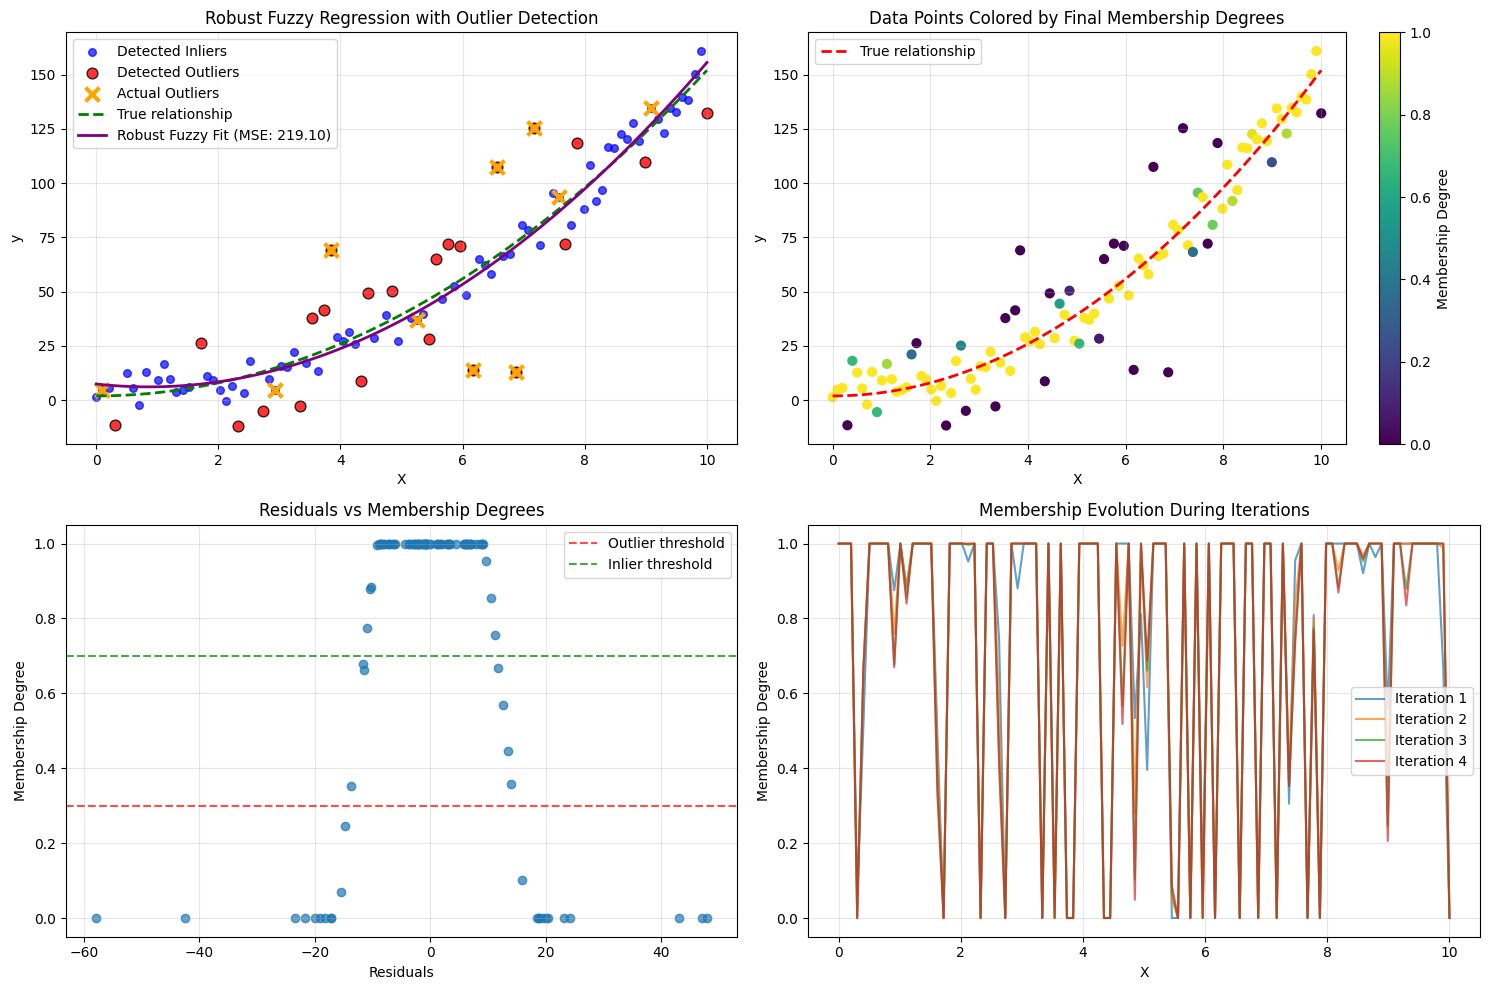

In [18]:
# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Data points with detected outliers
plt.subplot(2, 2, 1)
plt.scatter(X[inlier_indices_detected], y[inlier_indices_detected],
            c='blue', alpha=0.7, label='Detected Inliers', s=30)
plt.scatter(X[outlier_indices_detected], y[outlier_indices_detected],
            c='red', alpha=0.8, label='Detected Outliers', s=60, edgecolor='black')
plt.scatter(X[outlier_indices], y[outlier_indices],
            c='orange', marker='x', s=100, linewidth=3, label='Actual Outliers')
plt.plot(X, y_true, 'g--', linewidth=2, label='True relationship')
plt.plot(X, y_pred_robust, 'purple', linewidth=2, label=f'Robust Fuzzy Fit (MSE: {mse_robust:.2f})')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Robust Fuzzy Regression with Outlier Detection')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Membership degrees
plt.subplot(2, 2, 2)
scatter = plt.scatter(X, y, c=robust_fuzzy.final_memberships, cmap='viridis', s=40)
plt.colorbar(scatter, label='Membership Degree')
plt.plot(X, y_true, 'r--', linewidth=2, label='True relationship')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Data Points Colored by Final Membership Degrees')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Residuals vs Membership
plt.subplot(2, 2, 3)
plt.scatter(robust_fuzzy.final_residuals, robust_fuzzy.final_memberships, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Membership Degree')
plt.title('Residuals vs Membership Degrees')
plt.grid(True, alpha=0.3)
plt.axhline(0.3, color='r', linestyle='--', alpha=0.7, label='Outlier threshold')
plt.axhline(0.7, color='g', linestyle='--', alpha=0.7, label='Inlier threshold')
plt.legend()

# Plot 4: Membership evolution
plt.subplot(2, 2, 4)
for i in range(min(5, len(robust_fuzzy.membership_history))):
    plt.plot(X, robust_fuzzy.membership_history[i],
             alpha=0.7, label=f'Iteration {i+1}')
plt.xlabel('X')
plt.ylabel('Membership Degree')
plt.title('Membership Evolution During Iterations')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare with Traditional Methods

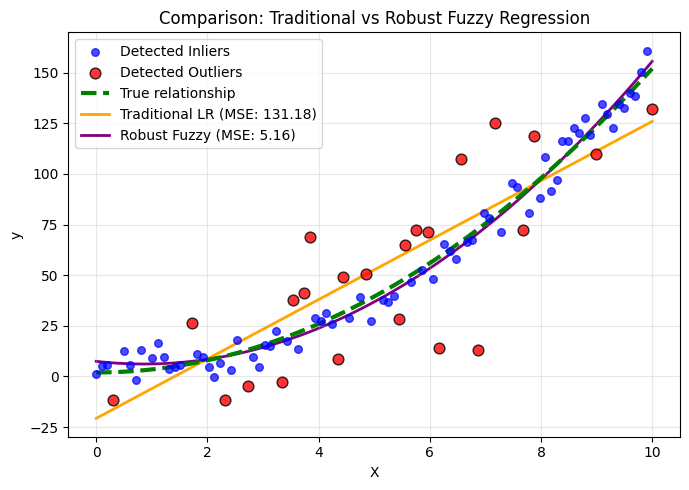

Model Comparison (MSE against true values):
Traditional Linear Regression:     131.185
Robust Fuzzy Regression:           5.160

Robust Fuzzy Improvement over Traditional LR: 96.1%


In [23]:


# + id="traditional-comparison"
# Traditional linear regression (sensitive to outliers)
traditional_lr = LinearRegression()
traditional_lr.fit(X_reshaped, y)
y_pred_traditional = traditional_lr.predict(X_reshaped)
mse_traditional = mean_squared_error(y, y_pred_traditional)
mse_traditional_true = mean_squared_error(y_true, y_pred_traditional)


# Visualization
plt.figure(figsize=(7, 5))

# Plot data points
plt.scatter(X[inlier_indices_detected], y[inlier_indices_detected],
            c='blue', alpha=0.7, label='Detected Inliers', s=30, zorder=3)
plt.scatter(X[outlier_indices_detected], y[outlier_indices_detected],
            c='red', alpha=0.8, label='Detected Outliers', s=60, edgecolor='black', zorder=3)
plt.plot(X, y_true, 'g--', linewidth=3, label='True relationship', zorder=2)

# Plot regression lines
plt.plot(X, y_pred_traditional, 'orange', linewidth=2,
         label=f'Traditional LR (MSE: {mse_traditional_true:.2f})', zorder=1)
plt.plot(X, y_pred_robust, 'purple', linewidth=2,
         label=f'Robust Fuzzy (MSE: {mse_true:.2f})', zorder=1)

plt.xlabel('X')
plt.ylabel('y')
plt.title('Comparison: Traditional vs Robust Fuzzy Regression')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Model Comparison (MSE against true values):")
print(f"Traditional Linear Regression:     {mse_traditional_true:.3f}")
print(f"Robust Fuzzy Regression:           {mse_true:.3f}")

# Calculate improvement
improvement = (mse_traditional_true - mse_true) / mse_traditional_true * 100
print(f"\nRobust Fuzzy Improvement over Traditional LR: {improvement:.1f}%")